In [29]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from importlib import reload
#import after torch else crash on Intel
from scipy.optimize import least_squares

from libs_unet.models import peakyfinder_0002
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [30]:
#Load training data for testing
with open(datapath / 'training' / 'el80_pairs_lg.pickle', 'rb') as f:
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)
    fracs = pickle.load(f)
    wave = pickle.load(f)
    spec_data = pickle.load(f)
    y_data = pickle.load(f)
# set number of elements
max_z = len(elem_symb)

In [31]:
#Scale data to account for source
nist_mult = 1.17
spec_data = nist_mult * spec_data
y_data = nist_mult * y_data

In [32]:
#split x_data into mutex low_int and log(hi_int) input channels
x_data = spec_data[:,None,:].copy()
x_shape = x_data.shape
new_inp = np.zeros((x_shape[0], 2, x_shape[2]))
log_cut = 2
new_inp[:,0,:] = np.where(np.log(x_data[:,0,:]) < log_cut, x_data[:,0,:], 0)
new_inp[:,1,:] = np.where(np.log(x_data[:,0,:]) >= log_cut, np.log(x_data[:,0,:]), 0)
x_data = new_inp.copy()
new_inp = None

In [33]:
#Create Dataset#
x_data = torch.tensor(x_data.astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
#x_data = torch.log(x_data + 1)
y_data = torch.log(y_data + 1)
#create dataset/dataloader for accessing/iterating
spec_ds = TensorDataset(x_data, y_data)
pred_bs = 1000
spec_dl = DataLoader(spec_ds, batch_size=pred_bs)


In [34]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = peakyfinder_0002.LIBSUNet(max_z,len(wave))
param_path = top_dir / 'trained_models' / 'el80_pairs_hilo_0002'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

In [35]:
#Run predictions for the entire dataset
model.eval()
with torch.no_grad():
    pred = torch.tensor([])
    for batch, X in enumerate(spec_dl):
        pred = torch.cat((pred, model(X[0])), dim=0)

Sample composition
Li:0.20000000298023224
Ba:0.800000011920929


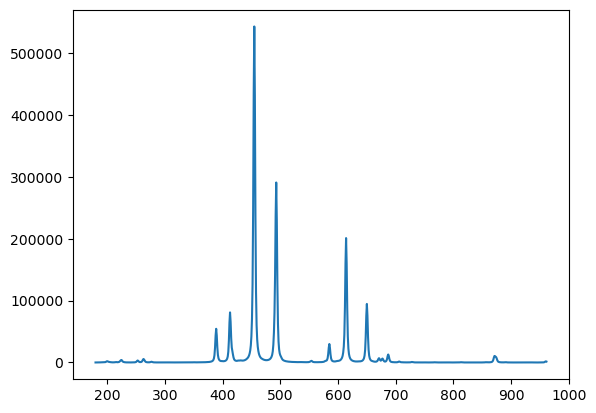

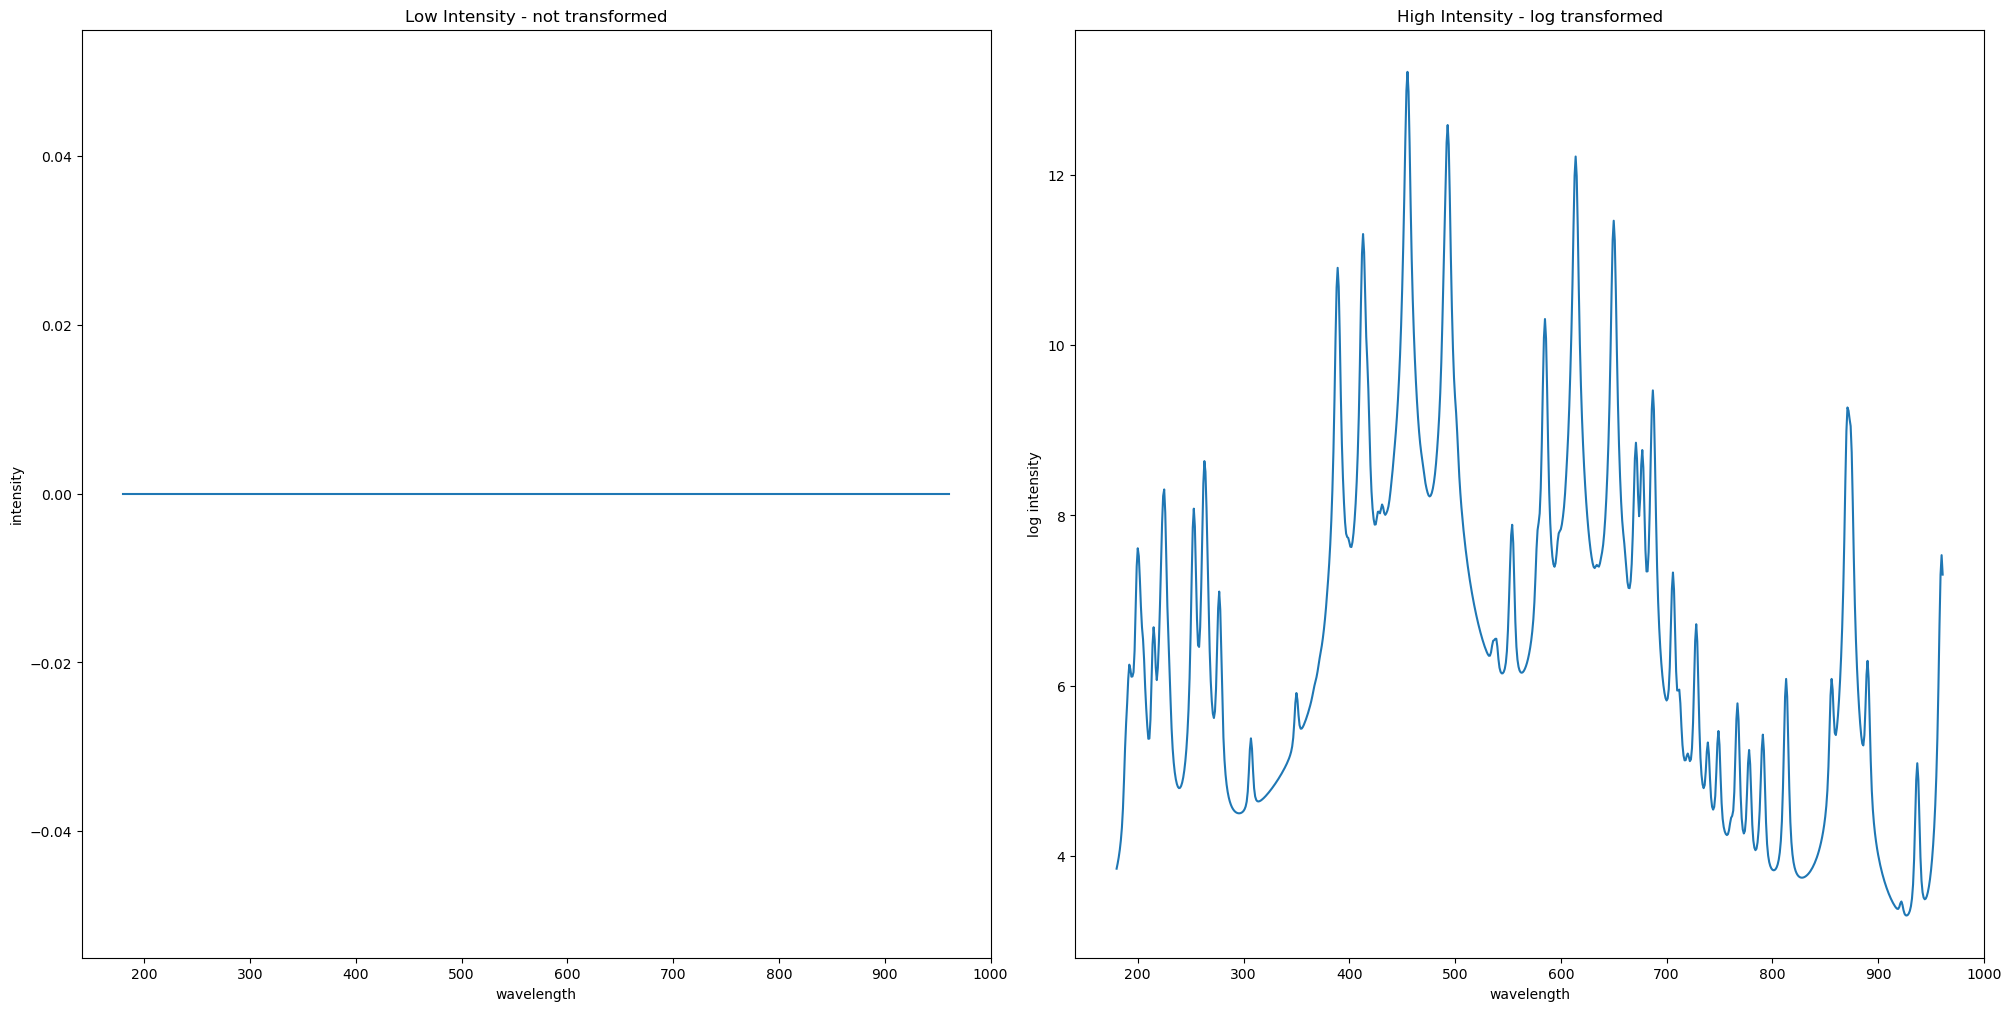

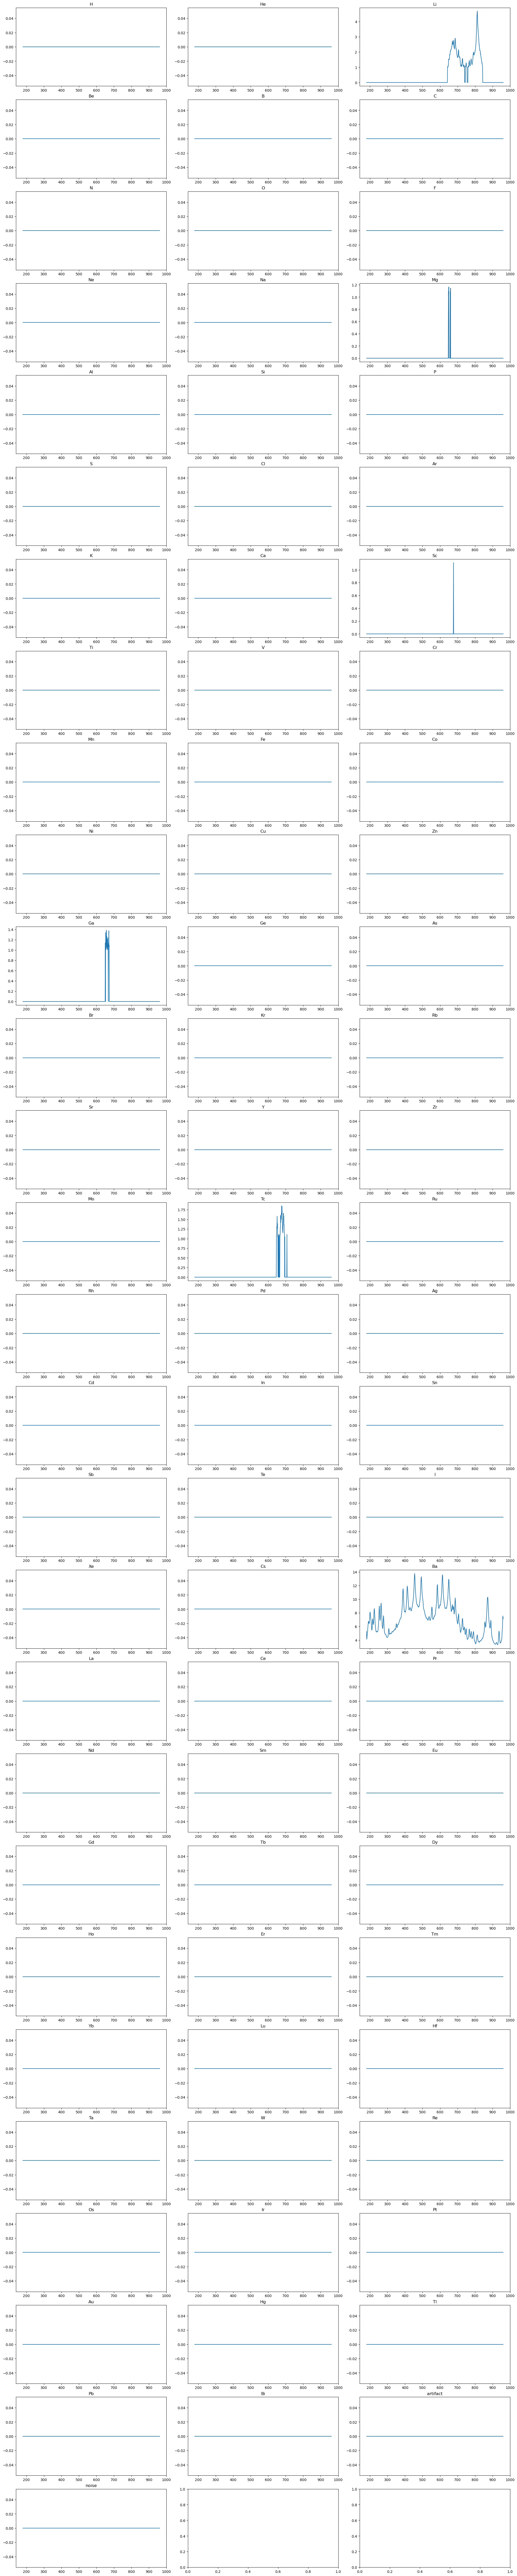

In [15]:
#look at the predicted vs. reference spectra
# sample and predicted data are all scaled and log transformed at this point
#TODO add initial section comparing specifically the y_samp and y_pred for true elements
plot_thresh = 0
i_samp = 1950 #vary up to 28,520
x_sample, y_sample = spec_ds[i_samp]

#print non-transformed but LIBS scaled input spectra
plt.plot(wave, spec_data[i_samp])

#composite spectra and components still in log transformed space used in model
print("Sample composition")
for el in elem_symb[np.nonzero(fracs[i_samp])]:
    print(f"{el}:{fracs[i_samp][el_index[el]]}")

        
#first plot the 2 transformed composite input spectra we're trying to learn from
fig, axs = plt.subplots(1, 2, figsize=(20,10), constrained_layout=True)
axs[0].set_title("Low Intensity - not transformed")
axs[0].plot(wave, x_sample[0])
axs[1].set_title("High Intensity - log transformed")
axs[1].plot(wave, x_sample[1])
[axs[i].set_xlabel('wavelength') for i in range(2)]
axs[0].set_ylabel('intensity')
axs[1].set_ylabel('log intensity')

#prediction (also transformed at this point)
y_pred = pred[i_samp].detach().numpy().copy() #[max_z+2][782] corresponding predictions for y_sample
y_pred[y_pred < plot_thresh] = 0

rows = 28
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20,100), constrained_layout=True)
plot_row = 0
plot_col = 0
for i in range(max_z + 2): #iterate over rows in pred array
    if i < max_z:
        axs[plot_row][plot_col].set_title(elem_symb[i])
    elif i == max_z:
        axs[plot_row][plot_col].set_title('artifact')
    else:
            axs[plot_row][plot_col].set_title('noise')
            
    axs[plot_row][plot_col].plot(wave, y_pred[i])
    if plot_col < 2:
        plot_col += 1
    else:
        plot_col = 0
        plot_row += 1

In [51]:
#Visual inspection indicates that model is picking up the some intended elements
#Let's find the threshold that maximizes % samples with correct elemental identification
#We're applying a peak height limit in log space here, so every 2.3 units ~order of mag

#Create the same dimension boolean for each prediction at a certain peak threshold (still log space)
#Log whether predicted elements match actual inputs so we can select best cutoff on % match
range_start = 1
range_end = 10
range_inc = 0.1
test_range = np.arange(range_start, range_end, range_inc)
matches = np.zeros(len(test_range)) #array of matches at each threshold

thresh_ind = 0
for thresh in test_range:
    for i in range(len(pred)):
        match = np.array_equal((np.max(pred[i,0:max_z,:].numpy(), axis=1) > thresh), (fracs[i] > 0))
        matches[thresh_ind] += 1 * match
    thresh_ind += 1

In [52]:
hit_rate = matches / len(x_data)
cutoff = np.zeros(len(test_range))
i = 0
for thresh in test_range:
    cutoff[i] = thresh
    i += 1

<function matplotlib.pyplot.show(close=None, block=None)>

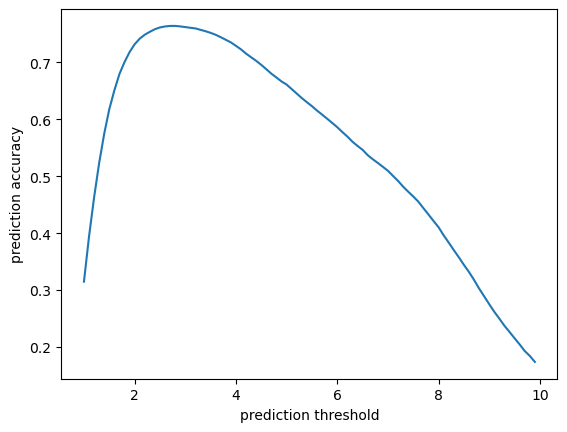

In [53]:
#review prediction accuracy by threshold
plt.plot(cutoff, hit_rate)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [54]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate.argmax()
print(f"max accuracy: { hit_rate[max_acc_ind]}")
print(f"at threshold: {cutoff[max_acc_ind]}")
#a cutoff of 10 maximizes prediction accuracy, refine within this range to one decimal point

max accuracy: 0.7639901823281907
at threshold: 2.8000000000000016


In [63]:
#characterize the nature of missed predictions in overall set
# for each element how often missed
# for each element how often incorrectly predicted
false_neg_dict = {}
false_pos_dict = {}
thresh = 2.8
for el in elem_symb:
    false_neg_dict[el] = 0
    false_pos_dict[el] = 0

for i in range(len(pred)):
    match = np.array_equal((np.max(pred[i,0:max_z,:].numpy(), axis=1) > thresh), (fracs[i] > 0))
    if not match:
        sample_el = elem_symb[fracs[i] > 0]
        pred_el = elem_symb[np.max(pred[i,0:max_z,:].numpy(), axis=1) > thresh]
        #log any missed elements
        for el in sample_el:
            if el not in pred_el:
                false_neg_dict[el] += 1
        #log any false predictions
        for el in pred_el:
            if el not in sample_el:
                false_pos_dict[el] += 1

<BarContainer object of 80 artists>

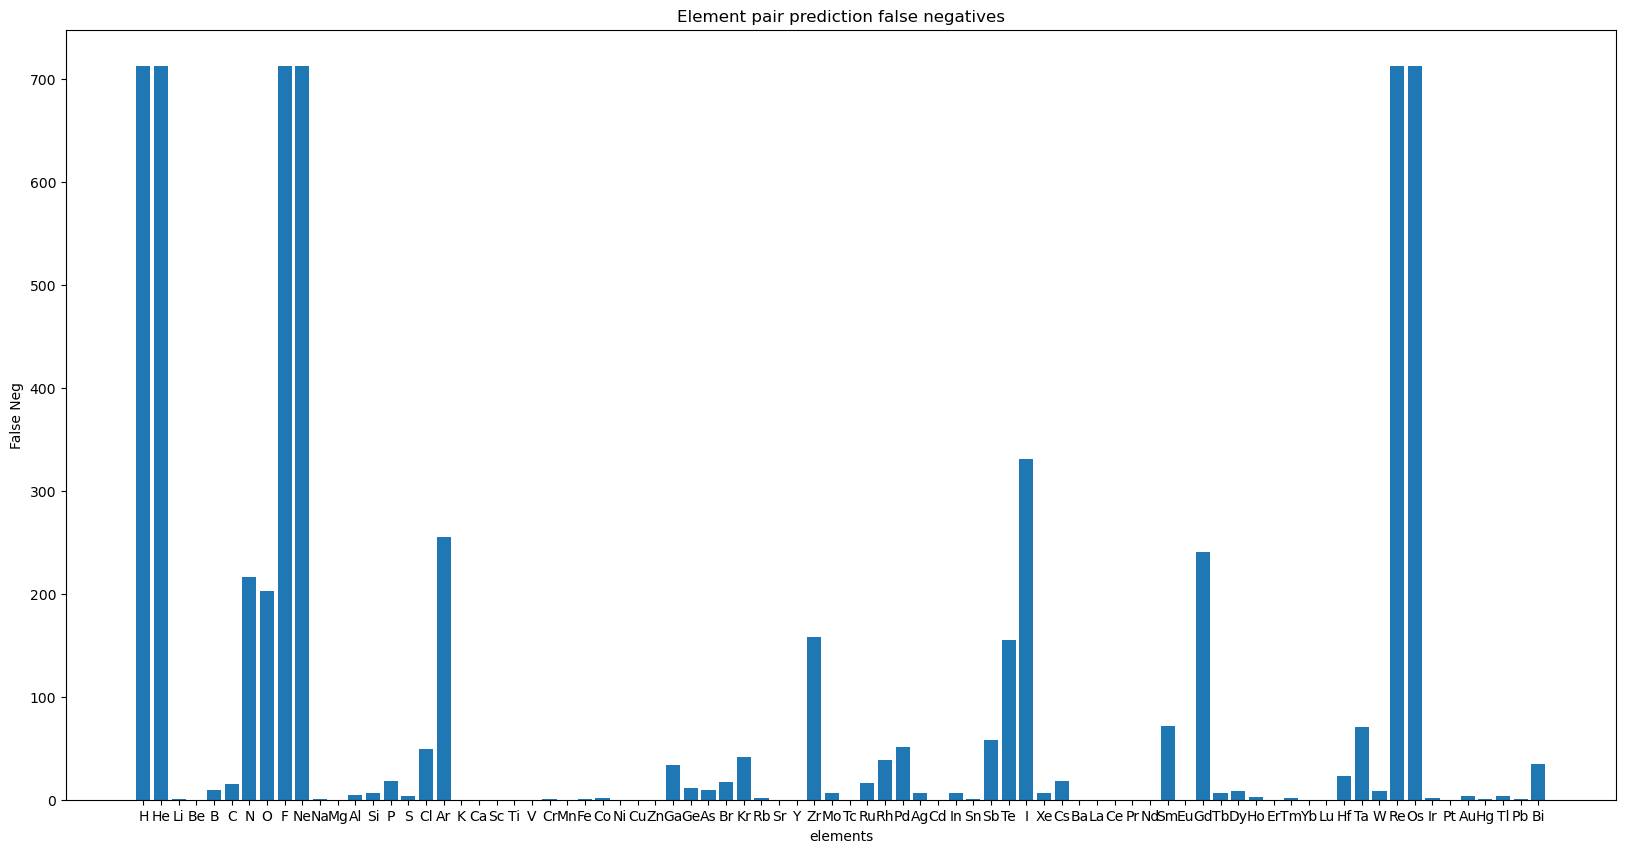

In [64]:
#Visualize false negatives
f_neg_x = np.array([])
f_neg_y = np.array([])
for x, y in false_neg_dict.items():
    f_neg_x = np.append(f_neg_x, x)
    f_neg_y = np.append(f_neg_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Neg')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false negatives')  # Add a title to the axes.
ax.bar(f_neg_x, f_neg_y)

<BarContainer object of 80 artists>

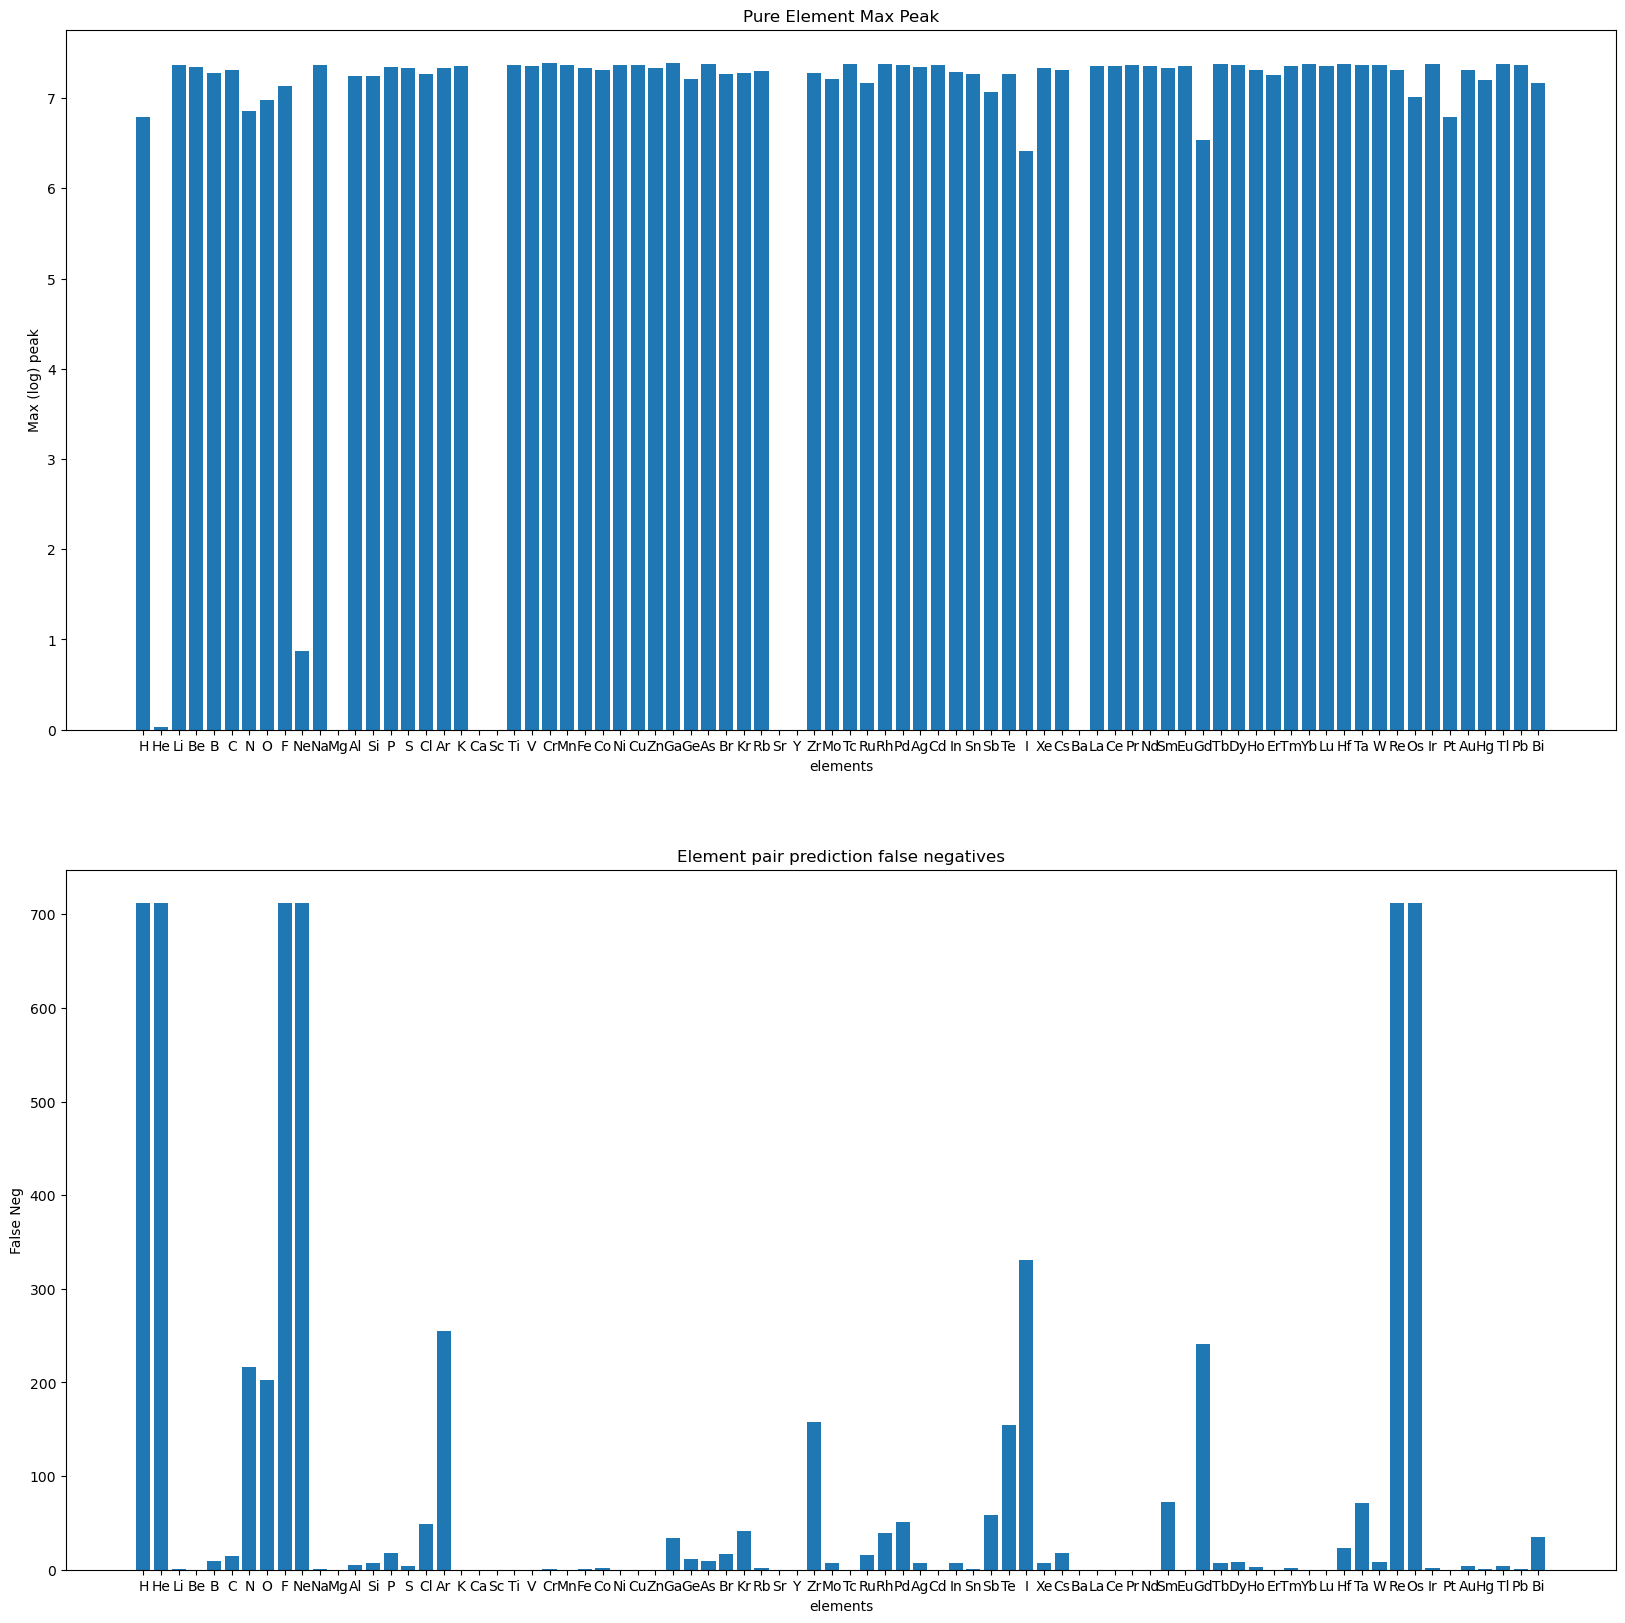

In [65]:
#Calculate the log of the most prominent peak for each element
#This is indicative of signal that the model has to scale/learn
max_log_int = np.zeros(len(elem_symb))
for i in range(len(elem_symb)):
    max_log_int[i] = torch.max(x_data[i][0])

fig, ax = plt.subplots(2,1, figsize=(20,20)) 
ax[0].set_xlabel('elements')  # Add an x-label to the axes.
ax[0].set_ylabel('Max (log) peak')  # Add a y-label to the axes.
ax[0].set_title('Pure Element Max Peak')  # Add a title to the axes.
ax[0].bar(elem_symb, max_log_int)
ax[1].set_xlabel('elements')  # Add an x-label to the axes.
ax[1].set_ylabel('False Neg')  # Add a y-label to the axes.
ax[1].set_title('Element pair prediction false negatives')  # Add a title to the axes.
ax[1].bar(f_neg_x, f_neg_y)


In [66]:
#Check if the pure elements were identified/learned
#This informs whether rescaling / iteration will likely work
for i in range(max_z):
    match = np.array_equal((np.max(pred[i,0:max_z,:].numpy(), axis=1) > thresh), (fracs[i] > 0))
    if not match:
        print(f"missed element: {elem_symb[i]}")

missed element: H
missed element: He
missed element: F
missed element: Ne
missed element: V
missed element: Re
missed element: Os


<BarContainer object of 80 artists>

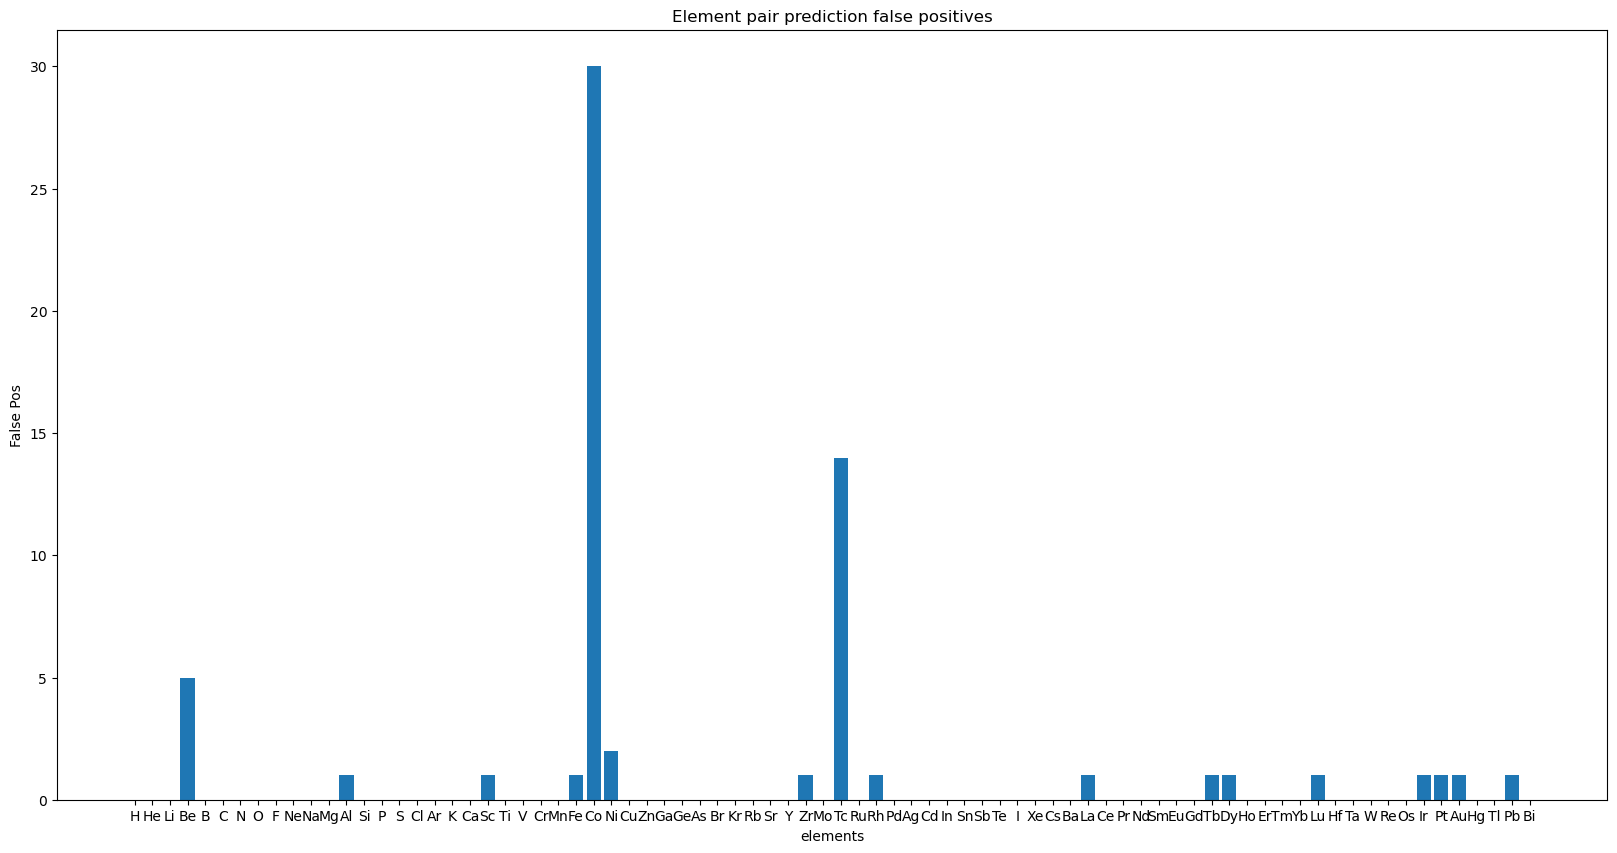

In [59]:
#Visualize false positives
f_pos_x = np.array([])
f_pos_y = np.array([])
for x, y in false_pos_dict.items():
    f_pos_x = np.append(f_pos_x, x)
    f_pos_y = np.append(f_pos_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Pos')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false positives')  # Add a title to the axes.
ax.bar(f_pos_x, f_pos_y)

In [27]:
#check if this model can identify elements in Li2CO3

max_z = len(elem_symb)
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)

y_custom = np.zeros((max_z + 2, len(wave)))
for el in spec_dict.keys():
    if el == 'art':
        y_custom[max_z] = spec_dict[el]
    elif el == 'noi':
        y_custom[max_z + 1] = spec_dict[el]
    elif el == 'comp':
        x_custom = spec_dict['comp']
    else:
        y_custom[el_index[el]] = spec_dict[el]

In [28]:
#scale and dimension data for model
x_custom = nist_mult * x_custom
x_custom = x_custom[None,None,:]
x_shape = x_custom.shape
new_inp = np.zeros((x_shape[0], 2, x_shape[2]))
log_cut = 2
new_inp[:,0,:] = np.where(np.log(x_custom[:,0,:]) < log_cut, x_custom[:,0,:], 0)
new_inp[:,1,:] = np.where(np.log(x_custom[:,0,:]) >= log_cut, np.log(x_custom[:,0,:]), 0)
x_custom = new_inp.copy()
new_inp = None

x_custom = torch.tensor(x_custom.astype('float32'))
y_custom = nist_mult * torch.tensor(y_custom[None,:,:].astype('float32'))
x_custom[x_custom < 0] = 0
y_custom[y_custom < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
#x_custom = torch.log(x_custom + 1)
y_custom = torch.log(y_custom + 1)

model.eval()
with torch.no_grad():
    pred_c = model(x_custom).detach().numpy().copy()

#see which elements are predicted
thresh = 2.8
pred_c_idx = np.max(pred_c[0,0:max_z,:], axis=1) > thresh
elem_symb[pred_c_idx] #array(['Li'], dtype='<U2')

array(['Li', 'C'], dtype='<U2')

This and/or other element identification models can feed into a LS fitting model constrained by these allowed elements. The model will find the LS fit of weighted atomic lines to the unknown spectra. The weights will correspond to the element abundance in the unknown sample.